In [100]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt     
import seaborn as sns 
import plotly.express as px
import pickle as pkl 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

In [14]:
df0 = pd.read_csv('./data/HR_dataset.csv')

In [15]:
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Initial EDA and data cleaning

In [16]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [17]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [23]:
# Rename and format column names

df0 = df0.rename(columns = {
    'satisfaction_level': 'satisfaction',
    'last_evaluation': 'evaluation',
    'number_project': 'project_count',
    'Work_accident': 'work_accident',
    'Department': 'department',
    'time_spend_company': 'tenure'
})

In [24]:
# Check for null values

df0.isnull().sum()

satisfaction             0
evaluation               0
project_count            0
average_montly_hours     0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [25]:
# Check for duplicates

df0.duplicated().sum()

3008

In [26]:
# Remove duplicates

df1 = df0.drop_duplicates()

In [27]:
df1.head()

,satisfaction,evaluation,project_count,average_montly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Visualizing the data

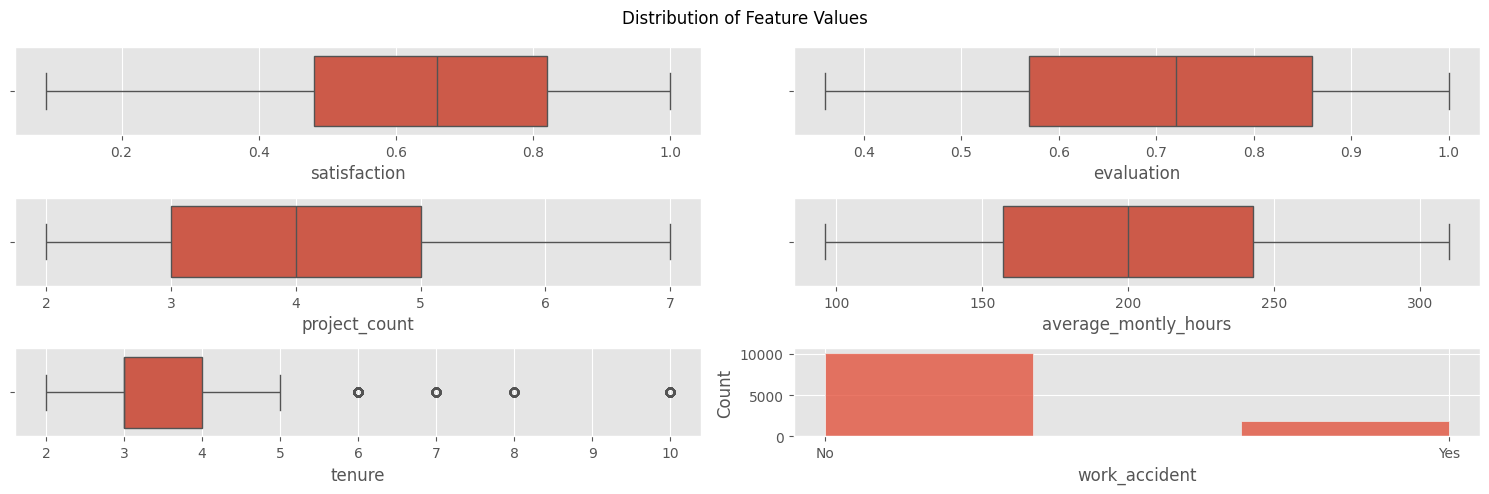

In [60]:
plt.style.use('ggplot')
fig , ax = plt.subplots(3, 2  , figsize = (15, 5))
sns.boxplot(data = df1, x = 'satisfaction' , ax = ax[0,0])
sns.boxplot(data = df1, x = 'evaluation', ax = ax[0,1])
sns.boxplot(data = df1, x = 'project_count', ax = ax[1,0])
sns.boxplot(data = df1, x = 'average_montly_hours', ax = ax[1,1])
sns.boxplot(data = df1, x = 'tenure', ax = ax[2,0])
plt.xticks([0,1],['No', 'Yes'])
sns.histplot(data = df1, x = 'work_accident', bins=3, ax = ax[2,1])

plt.suptitle('Distribution of Feature Values')
plt.tight_layout()
plt.show()

In [123]:
plot = px.histogram(
    df1,
    x='department',
    color= 'left',  
    template= 'ggplot2'    
).update_xaxes(categoryorder='total descending')
plot.show()

### Feature Correlation and Multicolinearity Analysis

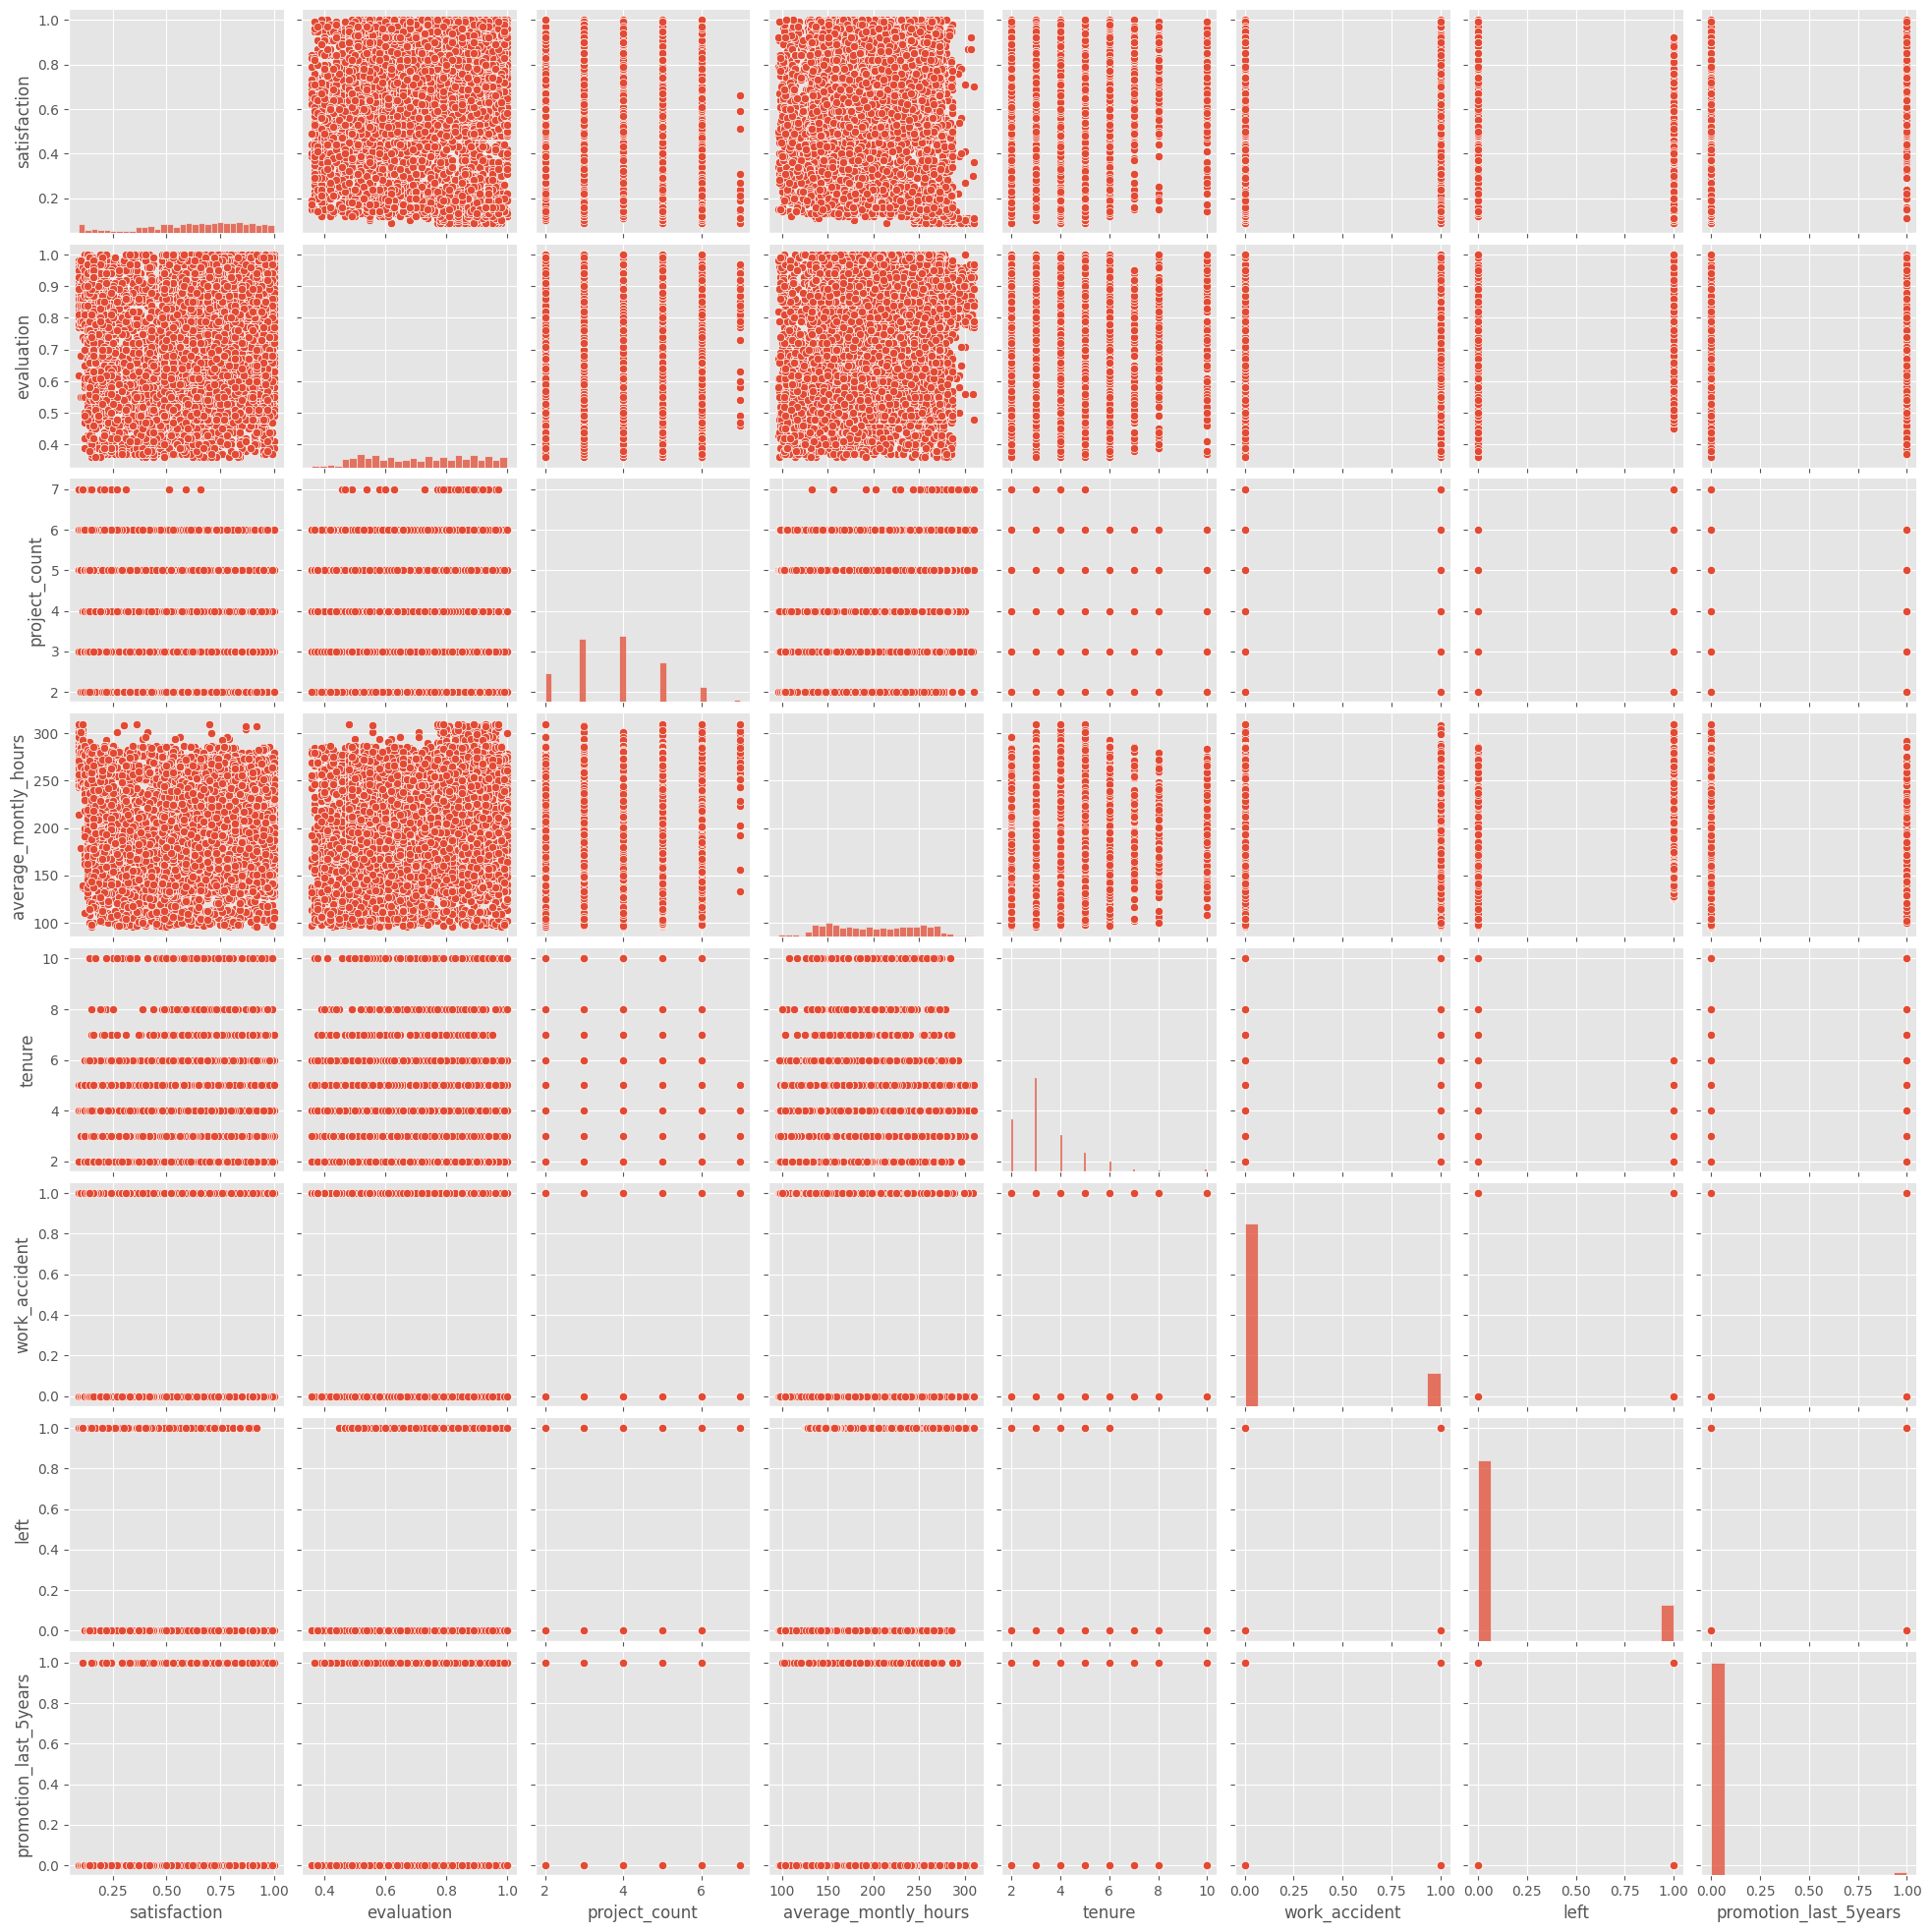

In [124]:
sns.pairplot(df1)

There isn't any clear linear relationship between the features and the target. The next pairplot shows the same only for the employees who left the company.

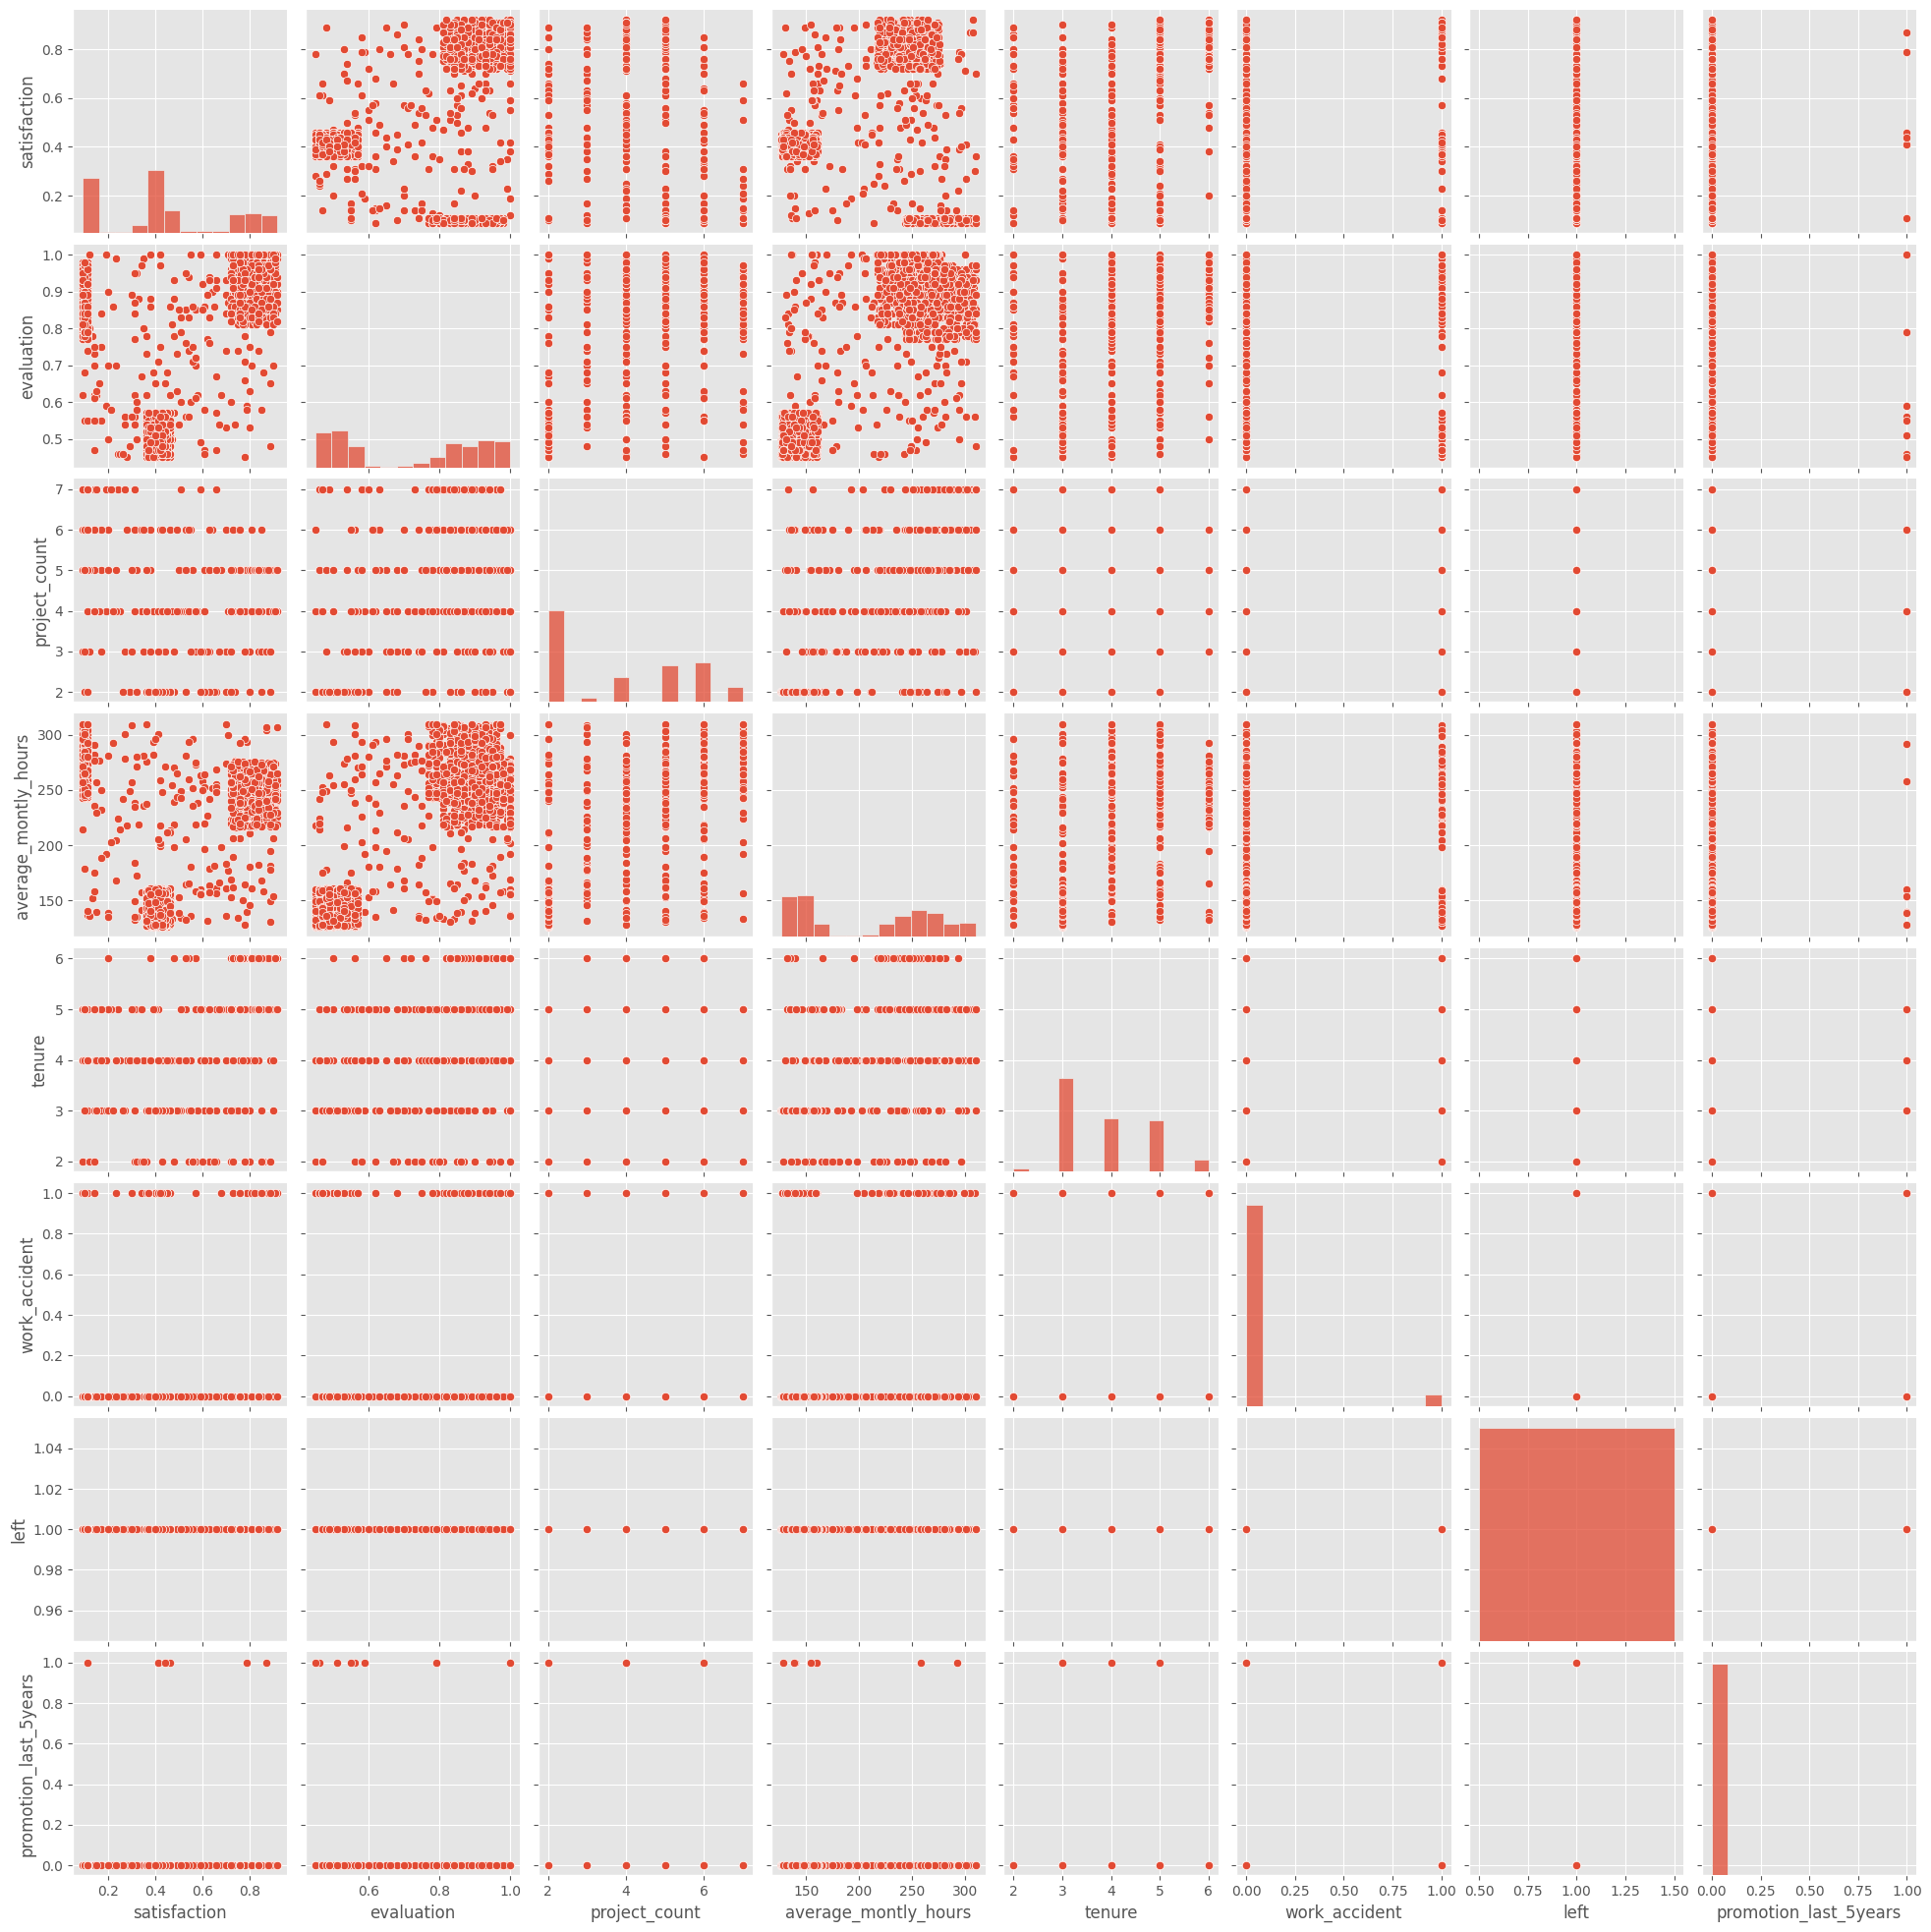

In [125]:
sns.pairplot(df1[df1.left == 1])

Here some clustering starts to appear in the continuous variables. 

### Category encoding

In [126]:
df1.salary = df1.salary.astype('category')
df1.department = df1.department.astype('category')  

df2 = pd.get_dummies(df1, drop_first = True, dtype='int')
df2.head()

/tmp/ipykernel_20275/2659480922.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20275/2659480922.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,satisfaction,evaluation,project_count,average_montly_hours,tenure,work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
